# This notebook collectd data on reference metabolites detection frequency in public METASPACE data

In [1]:
from pathlib import Path
from metaspace import SMInstance
import pickle
import json
import pandas as pd
from molmass import Formula
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

In [2]:
p = Path.cwd()

## Get relevant datasets from METASPACE

**Launch metaspace instance and get a list of all public datasets along with metadata**

In [3]:
sm = SMInstance()
dss = sm.datasets()

# pickle.dump(dss, open(p / 'all_datasets.pickle', "wb" ) )
# downloaded on 10/06/2024

In [4]:
# Load if presaved 
with open(p / 'all_datasets.pickle', 'rb') as file:
    dss = pickle.load(file)

**Collect unique values from all metadata categories**

In [5]:
categories = {
    'Organism': ['Sample_Information', 'Organism'],
    'Organism_Part': ['Sample_Information', 'Organism_Part'],
    'Condition': ['Sample_Information', 'Condition'],
    'Sample_Growth_Conditions': ['Sample_Information', 'Sample_Growth_Conditions'],
    'Sample_Stabilisation': ['Sample_Preparation', 'Sample_Stabilisation'],
    'Tissue_Modification': ['Sample_Preparation', 'Tissue_Modification'],
    'MALDI_Matrix': ['Sample_Preparation', 'MALDI_Matrix'],
    'MALDI_Matrix_Application': ['Sample_Preparation', 'MALDI_Matrix_Application'],
    'Analyzer': ['MS_Analysis', 'Analyzer'],
    'Additional_Information': ['Additional_Information', 'Supplementary']
}

data_list = []

for ds in dss:
    for category, path in categories.items():
        metadata = ds.metadata
        for key in path:
            metadata = metadata.get(key, None)
            if metadata is None:
                break
        
        if metadata is not None:
            data_list.append({
                'Category': category,
                'Unique Value': metadata,
                'Keep': ''
            })

for_curation = pd.DataFrame(data_list).drop_duplicates()
# for_curation.to_csv(p / 'categories_for_curation.csv', index=False)
# downloaded on 10/06/2024

**Manuallty curate categories and load curated data**

Categories were marked False if:
- Organism is not human, mouse or rat
- Data set does not contain tissue (e.g. cells, soil, test, dried droplet)
- Data set is for derivatised sample (e.g. FMP-10)
- Data set is for peptide analysis (e.g. tryptic digest)
- MALDI matrix used was not used in our project (e.g. metals, or derivatisation matrices)

In [6]:
curated = pd.read_csv(p / 'categories_curated.csv').dropna(how='all')

# Only irrelevant categories were marked False, others were left empty
curated.fillna({'Keep':True}, inplace=True)

C:\Users\saharuka\AppData\Local\Temp\ipykernel_23664\4199700246.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  curated.fillna({'Keep':True}, inplace=True)


**Use curated metadata to subset datasets**

In [7]:
# Get metadata for individual data sets 
categories = {
    'Organism': ['Sample_Information', 'Organism'],
    'Organism_Part': ['Sample_Information', 'Organism_Part'],
    'Condition': ['Sample_Information', 'Condition'],
    'Sample_Growth_Conditions': ['Sample_Information', 'Sample_Growth_Conditions'],
    'Sample_Stabilisation': ['Sample_Preparation', 'Sample_Stabilisation'],
    'Tissue_Modification': ['Sample_Preparation', 'Tissue_Modification'],
    'MALDI_Matrix': ['Sample_Preparation', 'MALDI_Matrix'],
    'MALDI_Matrix_Application': ['Sample_Preparation', 'MALDI_Matrix_Application'],
    'Polarity': ['MS_Analysis', 'Polarity'],
    'Ionisation_Source': ['MS_Analysis', 'Ionisation_Source'],
    'Analyzer': ['MS_Analysis', 'Analyzer'],
    'Additional_Information': ['Additional_Information', 'Supplementary']
}

data_list = []

for ds in dss:
    for category, path in categories.items():
        metadata = ds.metadata
        for key in path:
            metadata = metadata.get(key, None)
            if metadata is None:
                break
        
        if metadata is not None:
            data_list.append({
                'Dataset ID' : ds.id,
                'Category': category,
                'Value': metadata
            })

metadata_ds = pd.DataFrame(data_list).drop_duplicates()
metadata_ds.to_csv(p / 'dataset_metadata.csv', index=False)

In [8]:
# Identify categories to exclude 
non_kept_categories = curated[curated['Keep'] == False]['Unique Value'].values

# Exclude data sets with any non-kept categories
kept_datasets = []
for dataset_id, group in metadata_ds.groupby('Dataset ID'):
    
    # Check if the data set contains any non-kept category
    if not group['Value'].isin(non_kept_categories).any():
        kept_datasets.append(dataset_id)

In [9]:
print(f"Total datasets on METASPACE: {len(dss)}, selected for analysis: {len(kept_datasets)}")

Total datasets on METASPACE: 11074, selected for analysis: 4703


## In which data sets were reference metabolites detected?

**Download annotation tables for the subsetted data sets and filter them by formula**

In [10]:
# Load formulas of interest
p_formulas = p / "formulas.csv"
formulas = pd.read_csv(p_formulas)['formula'].drop_duplicates() # duplicates because one formula corresponds to two reference metabolites in this csv

In [11]:
database = ('HMDB', 'v4')
fdr=0.1

temp_dir = p / r"scratch/metaspace_tmp"
temp_dir.mkdir(exist_ok=True, parents=True)
filename = 'hmdb4_results.pickle'

all_results_dict = {}
counter = 0

In [ ]:
metadata_annotations = []
for ds in dss:
    
    # Only consider data sets pre-selected by metadata curation    
    if ds.id not in kept_datasets:
        continue
        
    # Only consider data sets that have finished processing and were annotated against HMDB (mandatory default database for a long time on METASPACE)
    if ds.status == 'FINISHED' and ds.id not in all_results_dict.keys():       
        if database in [(x.name, x.version) for x in ds.database_details]:
                        
            # Download annotation table
            tmp_tab = ds.results(database=database, fdr=fdr)
            n_annotations = tmp_tab.shape[0]

            # Exclude datasets with <5 annotations
            if n_annotations < 5:
                continue

            # Exclude datasets with no onsample filter metadata
            if tmp_tab['offSample'].isnull().all(): 
                continue

           # Process datasets that were not already processed              
            if ds.id not in all_results_dict.keys():

                tmp_filtered = tmp_tab[tmp_tab.index.get_level_values('formula').isin(formulas)]
                n_hits = tmp_filtered.index.get_level_values('formula').nunique()                
                all_results_dict[ds.id] = tmp_filtered[['offSample', 'intensity', 'fdr', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc']]
                counter +=1
                    
        
            metadata_annotations.append({'Dataset ID':ds.id,
                                         'Total annotations':n_annotations,
                                         'Reference metabolites':n_hits})
            
            # Save intermediate results every 1000 datasets  
            if (counter % 1000) == 0:
                print(counter)
                intermediate_results_path = temp_dir / f"{filename}_{str(counter)}_intermediate.pkl"
                with open(intermediate_results_path, "wb") as file:
                    pickle.dump(all_results_dict, file)

                # Save intermediate metadata
                metadata_file_path = temp_dir / f"{filename}_metadata.pkl"
                with open(metadata_file_path, "wb") as file:
                    pickle.dump(metadata_annotations, file)
                
pickle.dump(all_results_dict, 
            open(p / filename, "wb" ))

metadata_df = pd.DataFrame(metadata_annotations)
# metadata_df.to_csv(p / "annotation_metadata.csv", index=False)

In [12]:
# Load if presaved
metadata_df = pd.read_csv(p / "annotation_metadata.csv")
with open(p / filename, 'rb') as file:
    all_results_dict = pickle.load(file)

**Aggregate results per reference metabolite and data set**

In [13]:
onsample_list = []

for dataset_id, df in all_results_dict.items():

    df['onSample'] = ~df['offSample']
    
    # Group by formula, and check if any ion is on sample
    onsample = df.groupby('formula').agg({'onSample' : 'any'}).reset_index()
    onsample['ds_id'] = dataset_id
    onsample_list.append(onsample)

onsample_df = pd.concat(onsample_list)

## In which data sets can reference metabolites be detected based on the m/z range?

**Calculate masses of reference metabolites**

In [14]:
PROTON_MASS = 1.007276
POTASSIUM_ION_MASS = 38.96316

compounds = pd.DataFrame({'formula': formulas})
compounds['mz'] = compounds['formula'].apply(lambda f: Formula(f).isotope.mass)
compounds['mz_min'] = compounds['mz'] - PROTON_MASS
compounds['mz_max'] = compounds['mz'] + POTASSIUM_ION_MASS

**Get mass range of each data set**

In [15]:
def get_mz_range(ds):
    try:
        x = ds.diagnostic('IMZML_METADATA')['data']
        x = json.loads(x)
        min_mz = x.get('min_mz', None)
        max_mz = x.get('max_mz', None)
    except Exception as e:
        return {'ds_id': ds.id, 'range_min': None, 'range_max': None}
    
    return {'ds_id': ds.id, 'range_min': min_mz, 'range_max': max_mz}

In [ ]:
mz_list = []
for ds in dss:

    # Only considerdatasets pre-selected by metadata curation    
    if ds.id not in kept_datasets:
        continue

    # Collect info on the mass range
    mz_list.append(get_mz_range(ds))

metadata_mz = pd.DataFrame(mz_list)
metadata_mz.to_csv(p / 'dataset_metadata_mz_range.csv', index=False)

In [16]:
# Three datasets have 0 or inf metadata, fix it manually, values from METASPACE
# 2024-03-21_17h15m07s	1.86E+02	497
# 2021-06-08_00h55m20s	772	1.29E+03
# 2024-03-21_17h13m08s	112	452
# 2024-03-21_17h29m41s	1.12E+02	452
# 2023-11-01_11h33m19s	651	899.99475
# 2018-05-07_22h32m23s	350	1919
# 2018-02-12_14h15m39s	1.44E+02	1099.45166
# 2018-04-16_22h30m01s 183 1890
# 2017-03-16_20h43m09s 87 
# 2018-06-13_20h59m48s 162 1137

metadata_mz = pd.read_csv(p / 'dataset_metadata_mz_range_completed.csv')

**Which metabolites are within the mass range of which data set**

In [17]:
# Perform cross join to combine all formulas with all datasets
inrange_df = compounds.assign(key=1).merge(metadata_mz.assign(key=1), on='key').drop('key', axis=1)

# Check if formula falls within m/z range of each dataset
inrange_df['in_range'] = (inrange_df['range_min'] < inrange_df['mz_max']) & (inrange_df['range_max'] > inrange_df['mz_min'])

# Only store entries that are in range
inrange_df = inrange_df[inrange_df.in_range]

## Calculate detection frequency per metabolite, and then per chemical class

Ultimately we want to know in how many datasets reference metabolite was within measured m/z range and in how many datasets it was detected

The ratio of the two values is calculated and aggregated by dataset groups (e.g. all positive and negative datasets) and by compound class

In [18]:
# Filter dataset metadata based on the selected category
selected_categories = ['Polarity']
filtered_metadata = metadata_ds[metadata_ds['Category'].isin(selected_categories)].pivot(columns="Category", index="Dataset ID", values="Value").reset_index()

**Display number of eligible datasets per mz**

In [19]:
# Make a diagnostic plot to see in how many datasets on METASPACE (subset) can we expect metabolites to be detected
diagnostic = inrange_df.merge(filtered_metadata, left_on='ds_id', right_on='Dataset ID', how='left')

diagnostic = diagnostic.groupby(['formula', 'Polarity']).agg({
    'mz':'first',
    'in_range':'sum'
}).sort_values('mz').sort_values('Polarity', ascending=False).reset_index()

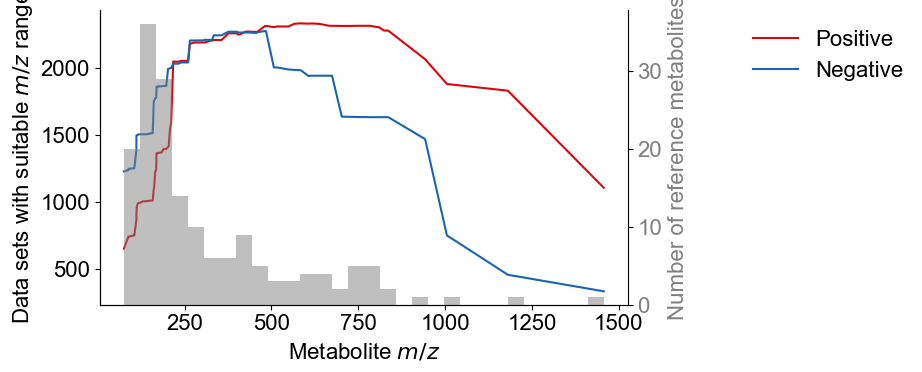

In [20]:
palette = {
    'Positive':'#DC050C',
    'Negative':'#1965B0' }

fig, ax1 = plt.subplots(figsize=(10,4))

# Create a second y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram of unique mz values on the second y-axis
sns.histplot(data=diagnostic.drop_duplicates(subset='mz'), x='mz', bins=30, 
             kde=False, color='gray', edgecolor=None, alpha=0.5, ax=ax2)
ax2.set_ylabel('Number of reference metabolites')
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_color('grey')

# Create the line plot on the first y-axis
sns.lineplot(data=diagnostic, x='mz', y='in_range', hue='Polarity', palette=palette, ax=ax1)
ax1.set_xlabel('Metabolite $m/z$')
ax1.set_ylabel('Data sets with suitable $m/z$ range')

# Beautify
sns.despine(ax=ax1, right=False)
sns.despine(ax=ax2)
ax1.legend(loc='upper left', bbox_to_anchor=(1.2, 1), frameon=False)

# Show plot
plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig(p / f"mz_range_plot_revision.png")
# plt.savefig(p / f"mz_range_plot_revision.pdf", transparent=True)

**Combine data**

In [21]:
# Combine information on whether reference meabolite is in range and onsample in each dataset, and add dataset metadata
metabolite_data = inrange_df[['formula', 'mz', 'ds_id', 'in_range']].merge(
    onsample_df, on=['formula','ds_id'], how='left').fillna(False).merge(
    filtered_metadata, left_on='ds_id', right_on='Dataset ID', how='left')

C:\Users\saharuka\AppData\Local\Temp\ipykernel_23664\3926643704.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  onsample_df, on=['formula','ds_id'], how='left').fillna(False).merge(


**Group datasets by polarity**

For each metabolite calculate:
- in how many datasets it was detected
- in how many detasets it was within m/z range to be detected
- ratio of there two values (let's call it detection frequency)

In [22]:
# Group datasets
group_datasets = metabolite_data.groupby(['formula', 'Polarity']).agg({
    'onSample':'sum',
    'in_range':'sum',
    'mz':'first'
}).reset_index()

group_datasets['frequency'] = group_datasets['onSample'] / group_datasets['in_range']

**Group metabolites by chemical class**

For each chemical subcalss calculate:
- average detection frequency

In [23]:
# Load classification
p_chem_class = p.parents[1] / r"matrix_comparison/5_data/custom_classification/custom_classification_v2.csv"
chem_class = pd.read_csv(p_chem_class, index_col='internal_id')[['name_short', 'main_coarse_class']].drop_duplicates()

# Map name_short and class to formula
formula_names = pd.read_csv(p_formulas)
mapped_data = group_datasets.merge(
    formula_names, on='formula', how='left').merge(
    chem_class, on='name_short', how='left')
mapped_data.to_csv(p / "mapped_data_for_supplement.csv", index=False)

# Summarise per chemical class
class_data = mapped_data.pivot_table(index=['Polarity', 'main_coarse_class'],
                          values = ['frequency', 'in_range'],
                          aggfunc = {'frequency':'median',
                                   'in_range':'mean'
                                }).reset_index()

# Prepare plot data
OX_order = ['Positive', 'Negative']
plot_data = class_data.pivot_table(columns= 'Polarity',
                       index='main_coarse_class',
                       values='frequency').loc[:,OX_order]

**Plot**

In [24]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

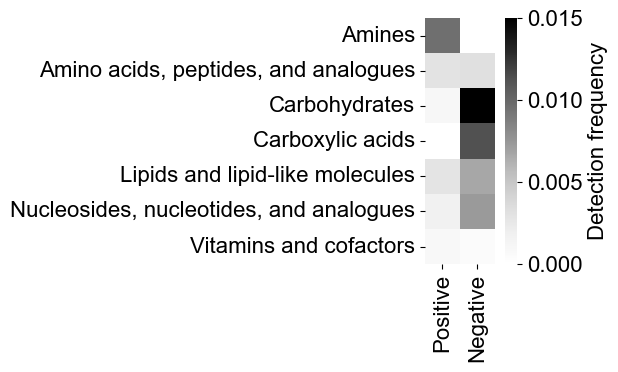

In [25]:
fname = f"detection_frequency_plot_revision"
plt.figure(figsize=(5,4))
ax = sns.heatmap(data=plot_data, 
                cmap=cmap,
                cbar_kws={'label': 'Detection frequency'},
                xticklabels=True,
                vmax=0.015
                )
ax.set(title="", xlabel="", ylabel="", aspect='equal')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(p / f"{fname}_median.png")
plt.savefig(p / f"{fname}_median.pdf", transparent=True)